# Research Request - Non-Revenue Vehicle Fleet Sizes #1236

How many non-revenue vehicles do transit agencies have. 

Also known as "service vehicles", Non-revenue vehicle data are excluded from UPT, VRM, VRH reports (since these NRV are not meant to carry passengers or make revenue).

NRVs are like support vehicles used to maintain transit operations (service/maintenance vehicles, other support.

Service Vehicle Inventory (Form A-35): "Transit agencies are required to report data on service vehicles, or vehicles which do not carry passengers.


In [1]:
import requests
import json
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns # for distplot

from calitp_data_analysis.tables import tbls
from siuba import _, filter, count, collect, show_query, select
from scipy.stats import zscore # find any outliers in the data 
from shared_utils import schedule_rt_utils

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)

GCS_PATH = "gs://calitp-analytics-data/data-analyses/ntd/"

In [2]:
keep_cols=[
    "ntd_id",
    "agency",
    "city",
    "organization_type",
    "reporter_type",
    #"agency_voms",
    "total_revenue_vehicles",
    "total_service_vehicles"
]

#ntd_service_veh = (
#    tbls.mart_ntd_annual_reporting.fct_vehicles_type_count_by_agency()
#    >> filter(
#        _.state == 'CA',
#       _.report_year == 2023
#    )
#    >> collect()
#)[keep_cols].reset_index(drop=True)


In [3]:
#ntd_service_veh.describe() # 0 revenue and service vehicles?

In [4]:
keep_cols_2=[
    "ntd_id",
    "agency",
    "city",
    "organization_type",
    "reporter_type",
    "mode",
    "type_of_service",
    "unlinked_passenger_trips",
    "vehicle_revenue_hours",

]

#ntd_ridership_metrics = (
#    tbls.mart_ntd_annual_reporting.fct_metrics()
#    >> filter(
#        _.state == 'CA',
#        _.report_year == 2023
#    )
#    >> collect()
#)[keep_cols_2].reset_index(drop=True)

## use `dim_annual_service_agencies` ntd_id, UPT, VRM, VRH for agencies?

How is this different from `dim_annual_agency_information`? are all reporter types included?

description:
>Provides transit agency-wide totals for service data for applicable agencies reporting to the National Transit Database. This view displays the data at a higher level (by agency), based on the "NTD Annual Data - Service (by Mode and Time Period)" dataset. In the years 2015-2021, you can find this data in the "Service" data table on NTD Program website, at https://transit.dot.gov/ntd/ntd-data. In versions of the data tables from before 2014, you can find data on service in the file called "Transit Operating Statistics: Service Supplied and Consumed."

In [5]:
keep_cols_annual_service=[
    "ntd_id",
    "agency",
    "reporter_type",
    "city",
    "primary_uza_name",
    "actual_vehicles_passenger_car_revenue_hours",
    "actual_vehicles_passenger_car_revenue_miles",
    "unlinked_passenger_trips_upt"
]

upt_vrm_vrh=(
    tbls.mart_ntd.dim_annual_service_agencies ()
    >> filter(
        _.state == "CA",
        _.report_year == 2023,

    )
    >> collect()
)[keep_cols_annual_service]

upt_vrm_vrh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 8 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   ntd_id                                       209 non-null    object 
 1   agency                                       209 non-null    object 
 2   reporter_type                                209 non-null    object 
 3   city                                         208 non-null    object 
 4   primary_uza_name                             165 non-null    object 
 5   actual_vehicles_passenger_car_revenue_hours  209 non-null    float64
 6   actual_vehicles_passenger_car_revenue_miles  209 non-null    float64
 7   unlinked_passenger_trips_upt                 209 non-null    float64
dtypes: float64(3), object(5)
memory usage: 13.2+ KB


In [6]:
col_check = ["reporter_type","agency"]

for i in col_check:
    display(upt_vrm_vrh[i].value_counts().head())
    
# LA county still showing multiple rows. so, consistent with `dim_annual_agency_information`

Reduced Reporter    84
Full Reporter       81
Rural Reporter      44
Name: reporter_type, dtype: int64

Los Angeles County                                                    10
City of South Gate                                                     1
City of Lynwood, dba: Lynwood Breeze                                   1
City of Malibu                                                         1
City of Manhattan Beach , dba: City of Manhattan Beach Dial-A-Ride     1
Name: agency, dtype: int64

In [7]:
# get unique NTD IDs from table
annual_service_ntd_id = upt_vrm_vrh["ntd_id"].unique().tolist()
type(annual_service_ntd_id)

list

In [8]:
# aggregate UPT and VRM by agency

upt_by_agency = upt_vrm_vrh.groupby(["ntd_id","agency"]).agg({
    "unlinked_passenger_trips_upt":"sum",
    "actual_vehicles_passenger_car_revenue_hours":"sum",
    "actual_vehicles_passenger_car_revenue_miles":"sum"
}).reset_index()

upt_by_agency.head()

,ntd_id,agency,unlinked_passenger_trips_upt,actual_vehicles_passenger_car_revenue_hours,actual_vehicles_passenger_car_revenue_miles
0,90003,"San Francisco Bay Area Rapid Transit District, dba: SF BART",50764402.0,2724074.0,85233749.0
1,90004,Golden Empire Transit District,3293593.0,289338.0,3924016.0
2,90006,Santa Cruz Metropolitan Transit District,3350026.0,214748.0,2975126.0
3,90008,"City of Santa Monica, dba: Big Blue Bus",7767725.0,416944.0,3920395.0
4,90009,"San Mateo County Transit District, dba: SamTrans",8773845.0,651839.0,7793698.0


## pull data from `fct_vehicles_type_count_by_agency`

In [2]:
veh_type_agency=(
    tbls.mart_ntd_annual_reporting.fct_vehicles_type_count_by_agency()
    >> filter(
        _.state == "CA",
        _.report_year == 2023,
    )
    >> select(
        _.agency,
        _.ntd_id,
        _.city,
        _.organization_type,
        _.total_service_vehicles,
        _.total_revenue_vehicles
    )
    >> collect()
)
veh_type_agency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   agency                  225 non-null    object 
 1   ntd_id                  225 non-null    object 
 2   city                    224 non-null    object 
 3   organization_type       225 non-null    object 
 4   total_service_vehicles  225 non-null    float64
 5   total_revenue_vehicles  225 non-null    float64
dtypes: float64(2), object(4)
memory usage: 10.7+ KB


In [3]:
veh_type_agency.sort_values(by="agency").head()

,agency,ntd_id,city,organization_type,total_service_vehicles,total_revenue_vehicles
58,Access Services,90157,El Monte,Independent Public Agency or Authority of Transit Service,17.0,1289.0
8,"Alameda-Contra Costa Transit District, dba: AC Transit",90014,Oakland,Independent Public Agency or Authority of Transit Service,154.0,799.0
70,Altamont Corridor Express,90182,Stockton,Independent Public Agency or Authority of Transit Service,8.0,36.0
154,Amador Transit,91000,Jackson,Independent Public Agency or Authority of Transit Service,3.0,18.0
80,"Anaheim Transportation Network, dba: Anaheim Regional Transportation",90211,Anaheim,Independent Public Agency or Authority of Transit Service,6.0,80.0


In [61]:
# merge in upt_vrm_vrh

non_rev_veh = veh_type_agency.merge(
    upt_vrm_vrh,
    on=["ntd_id","agency"],
    how="inner"
)

non_rev_veh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 0 to 208
Data columns (total 12 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   agency                                       209 non-null    object 
 1   ntd_id                                       209 non-null    object 
 2   city_x                                       208 non-null    object 
 3   organization_type                            209 non-null    object 
 4   total_service_vehicles                       209 non-null    float64
 5   total_revenue_vehicles                       209 non-null    float64
 6   reporter_type                                209 non-null    object 
 7   city_y                                       208 non-null    object 
 8   primary_uza_name                             165 non-null    object 
 9   actual_vehicles_passenger_car_revenue_hours  209 non-null    float64
 10  ac

## pulling data from NTD `2023 Annual Database Service Vehicle Inventory` 

Revenue Vehicle Inventory: https://www.transit.dot.gov/ntd/data-product/2023-annual-database-revenue-vehicle-inventory
>Contains operating statistics reported by mode and type of service. Categorized by vehicles operated and vehicles available in maximum service by day and time period.

Service Vehilce Inventory: https://www.transit.dot.gov/ntd/data-product/2023-annual-database-service-vehicle-inventory

>Contains operating statistics reported by mode and type of service. Categorized by vehicles operated and vehicles available in maximum service by day and time period.

In [9]:
#rev_url="https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-10/2023%20Revenue%20Vehicle%20Inventory.xlsx"
serv_url= "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-10/2023%20Service%20Vehicle%20Inventory.xlsx"

#ntd_rev_veh_inv = pd.read_excel(rev_url, engine="openpyxl")
ntd_serv_veh_inv = pd.read_excel(serv_url, engine='openpyxl')

#ntd_rev_veh_inv["NTD ID"] = ntd_rev_veh_inv["NTD ID"].astype(str)
ntd_serv_veh_inv["NTD ID"] = ntd_serv_veh_inv["NTD ID"].astype(str)

display(
    #ntd_rev_veh_inv.info(),
    ntd_serv_veh_inv.info()
)

# need to filter by CA agenicess

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17699 entries, 0 to 17698
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   State NTD ID                           1005 non-null   object 
 1   NTD ID                                 17699 non-null  object 
 2   Agency Name                            17699 non-null  object 
 3   Reporter Type                          17699 non-null  object 
 4   Group Plan Sponsor NTD ID              1939 non-null   object 
 5   Group Plan Sponsor Name                1939 non-null   object 
 6   Primary Mode Served                    17699 non-null  object 
 7   Secondary Modes Served                 6105 non-null   object 
 8   Reporting Module                       17699 non-null  object 
 9   Fleet ID                               17699 non-null  int64  
 10  Agency Service Fleet ID                13937 non-null  object 
 11  Se

None

### what are the service vehicles in `service vehicle inventory`?

In [10]:
ntd_serv_veh_inv[
    [
        #"Primary Mode Served",
        "Vehicle Type",
    ]
].value_counts()

Vehicle Type                         
Trucks and other Rubber Tire Vehicles    13984
Automobiles                               2818
Steel Wheel Vehicles                       897
dtype: int64

In [11]:
#long list,
# mix of mfg name, specific model name, but also some random numbers.
# 

ntd_serv_veh_inv["Service Fleet Name"].value_counts().sample(20)


2019 Chevy Tahoe                    2
Garbage Truck Dodge Ram             1
N-0721 2022 FORD F250 4X4           1
NRV 718                             1
2009, HR FLATBED, 5 YEAR ULB, HR    1
Service 6                           1
Ford E-150 Pass Wagon               1
N-0714 2022 FORD ESCAPE SE PHEV     1
2010FORD-TRANSIT CONNECT            2
Swing Master (SL-18020TC0029))      1
SV16                                1
NRV 303                             1
FORD_CONNECT_2019                   1
9202                                1
2020 Ford Explorer                  6
Ford Escape 2014                    1
TRUCK-08-F350                       1
A/Car Wrecker                       1
NRV 506                             1
2020-C                              1
Name: Service Fleet Name, dtype: int64

In [12]:
keep_col_0 = [
    "ntd_id",
    "agency_name",
    "reporter_type",
    "city",
    "primary_uza_name"
]

agency_info=(
    tbls.mart_ntd.dim_annual_agency_information()
    >> filter(
        _.state == "CA",
        _.year == 2023,
        _._is_current == True
    )
    >> collect()
)#[keep_col_0]

#agency_info = agency_info[keep_col_0]

display(agency_info.info(), agency_info.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   key                              237 non-null    object             
 1   year                             237 non-null    int64              
 2   ntd_id                           237 non-null    object             
 3   state_parent_ntd_id              59 non-null     object             
 4   agency_name                      237 non-null    object             
 5   reporter_acronym                 141 non-null    object             
 6   doing_business_as                120 non-null    object             
 7   division_department              130 non-null    object             
 8   legacy_ntd_id                    152 non-null    object             
 9   reported_by_ntd_id               59 non-null     object             
 10  re

None

,key,year,ntd_id,state_parent_ntd_id,agency_name,reporter_acronym,doing_business_as,division_department,legacy_ntd_id,reported_by_ntd_id,reported_by_name,reporter_type,reporting_module,organization_type,subrecipient_type,fy_end_date,original_due_date,address_line_1,address_line_2,p_o__box,city,state,zip_code,zip_code_ext,region,url,fta_recipient_id,ueid,service_area_sq_miles,service_area_pop,primary_uza_code,primary_uza_name,tribal_area_name,population,density,sq_miles,voms_do,voms_pt,total_voms,volunteer_drivers,personal_vehicles,tam_tier,number_of_state_counties,number_of_counties_with_service,state_admin_funds_expended,_valid_from,_valid_to,_is_current
0,f7665749d3746adda5a431fa3a661cab,2023,90012,None,San Joaquin Regional Transit District,RTD,San Joaquin RTD,None,9012,None,None,Full Reporter,Urban,Independent Public Agency or Authority of Transit Service,None,1688083200000,1698710400000,421 E Weber Ave,None,None,Stockton,CA,95202.0,3024.0,9,http://www.sanjoaquinrtd.com/,1665.0,CPC9CG13H741,1426.0,793229.0,85087.0,"Stockton, CA",None,414847.0,4486.669058,92.46,80.0,13.0,93,NaN,NaN,Tier II,NaN,NaN,NaN,2025-04-21 10:00:39.398012+00:00,2098-12-31 23:59:59.999999+00:00,True
1,7ce80892d75dfa2cf3854eed0a5e6650,2023,90119,None,City of Laguna Beach,CLB,Laguna Beach Transit,Transit and Community Services,9119,None,None,Reduced Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,505 Forest Ave,None,None,Laguna Beach,CA,92651.0,2332.0,9,https://www.lagunabeachcity.net/live-here/parking-and-transportation/trolleys,1705.0,PPPXANKDF7N7,9.0,23190.0,57709.0,"Mission Viejo--Lake Forest--Laguna Niguel, CA",None,646843.0,3953.022821,163.63,NaN,24.0,24,NaN,NaN,Tier II,NaN,NaN,NaN,2025-04-21 10:00:39.398012+00:00,2098-12-31 23:59:59.999999+00:00,True
2,28385dd650ac3d659cd6df9bdcd15698,2023,90171,None,City of Santa Clarita,SCT,Santa Clarita Transit,"Economic Development, Transit Division",9171,None,None,Full Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,23290 Valencia Blvd,None,None,Santa Clarita,CA,91355.0,1714.0,9,http://santaclaritatransit.com,5550.0,EVFFKS9KJAN8,89.0,273078.0,79309.0,"Santa Clarita, CA",None,278031.0,3571.563532,77.85,NaN,88.0,88,NaN,NaN,Tier II,NaN,NaN,NaN,2025-04-21 10:00:39.398012+00:00,2098-12-31 23:59:59.999999+00:00,True
3,68dd72edb74bedf3398054cf8b413c6c,2023,90173,None,Transit Joint Powers Authority for Merced County,None,Merced The Bus,None,9173,None,None,Full Reporter,Urban,Independent Public Agency or Authority of Transit Service,None,1688083200000,1698710400000,369 W 18Th St,None,None,Merced,CA,95340.0,4801.0,9,http://www.mercedthebus.com/,5731.0,LL3GXKW8LD91,310.0,136957.0,56251.0,"Merced, CA",None,150052.0,3483.359892,43.08,NaN,45.0,45,NaN,NaN,Tier II,NaN,NaN,NaN,2025-04-21 10:00:39.398012+00:00,2098-12-31 23:59:59.999999+00:00,True
4,20063b1634fcbd168c449cb250cedd42,2023,90201,None,City of Turlock,None,Turlock Transit,Transit,9201,None,None,Full Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,156 S Broadway,None,None,Turlock,CA,95380.0,5454.0,9,www.turlocktransit.com,2715.0,JDYXAB12QLG1,22.0,79203.0,89083.0,"Turlock, CA",None,79203.0,4688.330579,16.89,NaN,12.0,12,NaN,NaN,Tier II,NaN,NaN,NaN,2025-04-21 10:00:39.398012+00:00,2098-12-31 23:59:59.999999+00:00,True


In [13]:
len(agency_info["agency_name"].unique())

221

In [14]:
ca_ntd_id = agency_info["ntd_id"].unique().tolist()

len(ca_ntd_id)

237

In [15]:
agency_info.value_counts(subset=["agency_name","ntd_id"]).head() #why does Los Angeles County have multiple ntd id?

agency_name                                               ntd_id
Access Services                                           90157     1
Los Angeles County Metropolitan Transportation Authority  90154     1
Long Beach Transit                                        90023     1
Los Angeles County                                        90269     1
                                                          90270     1
dtype: int64

In [16]:
agency_info[agency_info["agency_name"]=="Los Angeles County"] #why does Los Angeles County have multiple ntd id?

,key,year,ntd_id,state_parent_ntd_id,agency_name,reporter_acronym,doing_business_as,division_department,legacy_ntd_id,reported_by_ntd_id,reported_by_name,reporter_type,reporting_module,organization_type,subrecipient_type,fy_end_date,original_due_date,address_line_1,address_line_2,p_o__box,city,state,zip_code,zip_code_ext,region,url,fta_recipient_id,ueid,service_area_sq_miles,service_area_pop,primary_uza_code,primary_uza_name,tribal_area_name,population,density,sq_miles,voms_do,voms_pt,total_voms,volunteer_drivers,personal_vehicles,tam_tier,number_of_state_counties,number_of_counties_with_service,state_admin_funds_expended,_valid_from,_valid_to,_is_current
70,4cfb8eeba35d39559c1f82f188dea254,2023,90270,None,Los Angeles County,LACDPW,None,"Department of Public Works, Transit Operations – Avocado Heights",None,None,None,Reduced Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,900 S Fremont Ave,None,None,Alhambra,CA,91803.0,NaN,9,https://www.dpw.lacounty.gov/landing/transportation.cfm,5566.0,None,9.0,15500.0,51445.0,"Los Angeles--Long Beach--Anaheim, CA",None,12237376.0,7476.284117,1636.83,NaN,1.0,1,NaN,NaN,Tier II,NaN,NaN,NaN,2025-04-21 10:00:39.398012+00:00,2098-12-31 23:59:59.999999+00:00,True
98,71d2dade342db4340e37c10643ce9aec,2023,90277,None,Los Angeles County,None,None,"Department of Public Works, Transit Operations, Whittier Et Al DR",None,None,None,Reduced Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,900 S Fremont Ave,None,None,Alhambra,CA,91803.0,1331.0,9,https://dpw.lacounty.gov/transit/DAR.aspx#pageTitle,5566.0,ZLJUW5L9K685,42.0,284527.0,51445.0,"Los Angeles--Long Beach--Anaheim, CA",None,12237376.0,7476.284117,1636.83,NaN,10.0,10,NaN,NaN,Tier II,NaN,NaN,NaN,2025-04-21 10:00:39.398012+00:00,2098-12-31 23:59:59.999999+00:00,True
127,508feef1e02e2887b97485a5a6d12e00,2023,90269,None,Los Angeles County,None,LA County Public Works,"Department of Public Works, Transit Operations, Athens MB",None,None,None,Reduced Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,900 S Fremont Ave,None,None,Alhambra,CA,91803.0,1331.0,9,www.lagobus.info,5566.0,ZLJUW5L9K685,25.0,23159.0,51445.0,"Los Angeles--Long Beach--Anaheim, CA",None,12237376.0,7476.284117,1636.83,NaN,2.0,2,NaN,NaN,Tier II,NaN,NaN,NaN,2025-04-21 10:00:39.398012+00:00,2098-12-31 23:59:59.999999+00:00,True
128,a70b64d2299d22022a9187c3d705b778,2023,90272,None,Los Angeles County,LACDPW,None,"Department of Public Works, Transit Operations – East Valinda",None,None,None,Reduced Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,900 S Fremont Ave,None,None,Alhambra,CA,91803.0,NaN,9,https://www.dpw.lacounty.gov/landing/transportation.cfm,5566.0,None,15.0,22822.0,51445.0,"Los Angeles--Long Beach--Anaheim, CA",None,12237376.0,7476.284117,1636.83,NaN,1.0,1,NaN,NaN,Tier II,NaN,NaN,NaN,2025-04-21 10:00:39.398012+00:00,2098-12-31 23:59:59.999999+00:00,True
144,b2e1b0be7fdda71c8c78ba8be990d8f8,2023,90278,None,Los Angeles County,None,None,"Department of Public Works, Transit Operations, Willowbrook MB",None,None,None,Reduced Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,900 S Fremont Ave,None,None,Alhambra,CA,91803.0,1331.0,9,http://www.dpw.lacounty.gov/transit,5566.0,ZLJUW5L9K685,36.0,24798.0,51445.0,"Los Angeles--Long Beach--Anaheim, CA",None,12237376.0,7476.284117,1636.83,NaN,3.0,3,NaN,NaN,Tier II,NaN,NaN,NaN,2025-04-21 10:00:39.398012+00:00,2098-12-31 23:59:59.999999+00:00,True
161,6b9f98f0483d5880ab84d2f417b38503,2023,90273,None,Los Angeles County,LACDPW,None,"Department of Public Works, Transit Operations - Florence Firestone",None,None,None,Reduced Reporter,Urban,"City, County or Local Government Unit or Department of Transportati

## filter rev and service list by ca ntd id

In [17]:
## need to filter the rev and serv veh inv sheet by annual service ntd id, then join the upt_vrm_vrh data

# rev and serv veh inv
#ntd_rev_veh_inv
#ntd_srv_veh_inv

#metrics
#upt_vrm_vrh

#ntd ID
#annual_service_ntd_id


#ca_rev_veh = ntd_rev_veh_inv[ntd_rev_veh_inv["NTD ID"].isin(annual_service_ntd_id)]

ca_serv_veh = ntd_serv_veh_inv[ntd_serv_veh_inv["NTD ID"].isin(annual_service_ntd_id)]


display(
    #len(ca_rev_veh),
    len(ca_serv_veh)
)

2741

In [18]:
ca_serv_veh.describe()

,Fleet ID,Year of Manufacture,Number of Vehicles,Useful Life Benchmark,Percent Agency Capital Responsibility,Estimated Cost,Year Dollar of the Estimated Cost
count,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2.741000e+03,2741.000000
mean,17057.534841,2012.197008,1.942357,11.449106,99.854068,1.552494e+05,2016.551623
std,10193.421770,8.749674,3.290602,5.341620,3.818015,5.934207e+05,6.517969
min,1.000000,1958.000000,0.000000,4.000000,0.000000,1.000000e+03,1973.000000
25%,8508.000000,2009.000000,1.000000,8.000000,100.000000,2.860500e+04,2014.000000
50%,16592.000000,2014.000000,1.000000,10.000000,100.000000,4.464017e+04,2018.000000
75%,25885.000000,2018.000000,1.000000,14.000000,100.000000,9.739100e+04,2021.000000
max,31904.000000,2023.000000,70.000000,43.000000,100.000000,1.417500e+07,2023.000000


In [19]:
ca_serv_veh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2741 entries, 14737 to 17698
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   State NTD ID                           77 non-null     object 
 1   NTD ID                                 2741 non-null   object 
 2   Agency Name                            2741 non-null   object 
 3   Reporter Type                          2741 non-null   object 
 4   Group Plan Sponsor NTD ID              111 non-null    object 
 5   Group Plan Sponsor Name                111 non-null    object 
 6   Primary Mode Served                    2741 non-null   object 
 7   Secondary Modes Served                 1042 non-null   object 
 8   Reporting Module                       2741 non-null   object 
 9   Fleet ID                               2741 non-null   int64  
 10  Agency Service Fleet ID                2247 non-null   object 
 11 

In [20]:
# group by agency
ca_serv_veh_agg = ca_serv_veh.groupby([
    "NTD ID",
    "Agency Name",
    "Reporter Type"
])["Number of Vehicles"].sum().reset_index()

ca_serv_veh_agg.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   NTD ID              110 non-null    object
 1   Agency Name         110 non-null    object
 2   Reporter Type       110 non-null    object
 3   Number of Vehicles  110 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 3.6+ KB


## calculate service vehicle ratios


In [21]:
display(
    upt_by_agency.columns,
    ca_serv_veh_agg.columns
)

Index(['ntd_id', 'agency', 'unlinked_passenger_trips_upt',
       'actual_vehicles_passenger_car_revenue_hours',
       'actual_vehicles_passenger_car_revenue_miles'],
      dtype='object')

Index(['NTD ID', 'Agency Name', 'Reporter Type', 'Number of Vehicles'], dtype='object')

In [22]:
# join ntd_service_veh and upt_vrm_vrh

service_veh_upt = ca_serv_veh_agg.merge(upt_by_agency, left_on="NTD ID", right_on="ntd_id", how="inner", indicator=True)
service_veh_upt.head()

,NTD ID,Agency Name,Reporter Type,Number of Vehicles,ntd_id,agency,unlinked_passenger_trips_upt,actual_vehicles_passenger_car_revenue_hours,actual_vehicles_passenger_car_revenue_miles,_merge
0,90003,San Francisco Bay Area Rapid Transit District,Full Reporter,660,90003,"San Francisco Bay Area Rapid Transit District, dba: SF BART",50764402.0,2724074.0,85233749.0,both
1,90004,Golden Empire Transit District,Full Reporter,26,90004,Golden Empire Transit District,3293593.0,289338.0,3924016.0,both
2,90006,Santa Cruz Metropolitan Transit District,Full Reporter,41,90006,Santa Cruz Metropolitan Transit District,3350026.0,214748.0,2975126.0,both
3,90008,City of Santa Monica,Full Reporter,20,90008,"City of Santa Monica, dba: Big Blue Bus",7767725.0,416944.0,3920395.0,both
4,90009,San Mateo County Transit District,Full Reporter,78,90009,"San Mateo County Transit District, dba: SamTrans",8773845.0,651839.0,7793698.0,both


In [23]:
# identify zscores
z_score = service_veh_upt[[
    "actual_vehicles_passenger_car_revenue_hours",
    "Number of Vehicles",
    "unlinked_passenger_trips_upt"
]].apply(zscore)

In [24]:
# remove outliers
threshold = 3
service_v_upt_no_outliers = service_veh_upt[(z_score.abs() < threshold).all(axis=1)]


In [25]:
display(
    "initial data",
    service_veh_upt.describe(),
    "outliers removed",
    service_v_upt_no_outliers.describe()
)
# can see that the min/max values of each col were adjusted

'initial data'

,Number of Vehicles,unlinked_passenger_trips_upt,actual_vehicles_passenger_car_revenue_hours,actual_vehicles_passenger_car_revenue_miles
count,110.000000,1.100000e+02,1.100000e+02,1.100000e+02
mean,48.400000,7.502405e+06,3.564563e+05,5.258683e+06
std,167.182436,3.045190e+07,9.567121e+05,1.423065e+07
min,0.000000,6.897000e+03,2.937000e+03,2.718700e+04
25%,2.000000,1.697210e+05,2.784650e+04,3.820270e+05
50%,8.000000,6.588965e+05,7.746500e+04,1.103403e+06
75%,22.750000,2.693204e+06,2.247842e+05,3.154542e+06
max,1498.000000,2.763024e+08,8.220160e+06,1.094675e+08


'outliers removed'

,Number of Vehicles,unlinked_passenger_trips_upt,actual_vehicles_passenger_car_revenue_hours,actual_vehicles_passenger_car_revenue_miles
count,107.000000,1.070000e+02,1.070000e+02,1.070000e+02
mean,24.504673,3.355795e+06,2.333059e+05,3.360262e+06
std,49.946835,8.571336e+06,4.558187e+05,6.199244e+06
min,0.000000,6.897000e+03,2.937000e+03,2.718700e+04
25%,2.000000,1.623065e+05,2.775850e+04,3.774075e+05
50%,7.000000,6.400990e+05,6.779000e+04,9.965060e+05
75%,21.000000,2.674811e+06,2.144505e+05,2.995482e+06
max,356.000000,6.851136e+07,2.573209e+06,3.409595e+07


In [26]:
# calculate ratios

# service vehicles per ....(10,000 upt, 1,000 vrh)
multiplier= 10000

service_v_upt_no_outliers["srv_upt_ratio"] = (service_v_upt_no_outliers["Number of Vehicles"] / service_v_upt_no_outliers["unlinked_passenger_trips_upt"])*multiplier

service_v_upt_no_outliers["srv_vrh_ratio"] = (service_v_upt_no_outliers["Number of Vehicles"] / service_v_upt_no_outliers["actual_vehicles_passenger_car_revenue_hours"])*multiplier

service_v_upt_no_outliers.describe()

/tmp/ipykernel_714/1299761564.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  service_v_upt_no_outliers["srv_upt_ratio"] = (service_v_upt_no_outliers["Number of Vehicles"] / service_v_upt_no_outliers["unlinked_passenger_trips_upt"])*multiplier
/tmp/ipykernel_714/1299761564.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  service_v_upt_no_outliers["srv_vrh_ratio"] = (service_v_upt_no_outliers["Number of Vehicles"] / service_v_upt_no_outliers["actual_vehicles_passenger_car_revenue_hours"])*multiplier


,Number of Vehicles,unlinked_passenger_trips_upt,actual_vehicles_passenger_car_revenue_hours,actual_vehicles_passenger_car_revenue_miles,srv_upt_ratio,srv_vrh_ratio
count,107.000000,1.070000e+02,1.070000e+02,1.070000e+02,107.000000,107.000000
mean,24.504673,3.355795e+06,2.333059e+05,3.360262e+06,0.253422,1.633812
std,49.946835,8.571336e+06,4.558187e+05,6.199244e+06,0.352802,1.700732
min,0.000000,6.897000e+03,2.937000e+03,2.718700e+04,0.000000,0.000000
25%,2.000000,1.623065e+05,2.775850e+04,3.774075e+05,0.050739,0.554195
50%,7.000000,6.400990e+05,6.779000e+04,9.965060e+05,0.130647,1.196615
75%,21.000000,2.674811e+06,2.144505e+05,2.995482e+06,0.264105,2.189939
max,356.000000,6.851136e+07,2.573209e+06,3.409595e+07,1.592892,11.103644


## A: Total Number of Non-Revenue Vehicles
aka Service Vehicles

In [27]:
total_non_rev_veh = service_v_upt_no_outliers["Number of Vehicles"].sum()
total_non_rev_veh

2622

## A: Number of Non-Revenue vehicles vs GTFS service hours

anything in the warehouse that can tell me service hours?

if i have to do this myself, what tables do i need?
- earliest `start time` and latest `stop time` for each `agency`?

Spoke with Amanda about service hours and GTFS digets
- advised to see the `service hours` they used in the Digest to see if ir can be useful



In [28]:
# url pulled from gtfs digest service hour section
digest_service_hours = "gs://calitp-analytics-data/data-analyses/rt_vs_schedule/digest/total_scheduled_service_hours.parquet"

service_hours = pd.read_parquet(digest_service_hours)

service_hours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24912 entries, 0 to 24911
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 24912 non-null  object 
 1   month_year           24912 non-null  object 
 2   weekday_weekend      24912 non-null  object 
 3   departure_hour       24912 non-null  Int64  
 4   service_hours        24912 non-null  float64
 5   daily_service_hours  24912 non-null  float64
dtypes: Int64(1), float64(2), object(3)
memory usage: 1.2+ MB


In [29]:
service_hours["name"].value_counts()

Bay Area 511 SamTrans Schedule                          288
Bay Area 511 SFO AirTrain Schedule                      288
LA Metro Bus Schedule                                   288
LAX FlyAway Schedule                                    282
San Diego Schedule                                      276
Bay Area 511 Santa Clara Transit Schedule               273
Bay Area 511 Muni Schedule                              264
Bay Area 511 Marin Schedule                             264
Bay Area 511 AC Transit Schedule                        264
OCTA Schedule                                           264
Anaheim Resort Schedule                                 262
Bay Area 511 Golden Gate Transit Schedule               252
Bay Area 511 BART Schedule                              248
Riverside Schedule                                      244
Yolobus Schedule                                        240
Sacramento Schedule                                     240
North County Schedule                   

In [30]:
#group by name?

schedule_service_hours = service_hours.groupby("name").agg({
    "daily_service_hours":"sum"
}).reset_index()

schedule_service_hours.head()

,name,daily_service_hours
0,Alhambra Schedule,275.08
1,Amador Schedule,140.46
2,Amtrak Schedule,24870.05
3,Anaheim Resort Schedule,30709.12
4,Antelope Valley Transit Authority Schedule,3665.97


service hour uses schcedule name
need to crosswalk agency name/ntd id to schedule name...again


In [31]:
# via proposed_changes NB

#crosswalk from gtfs dataset key to orgs
gcs_crosswalk = pd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/gtfs_schedule/crosswalk/gtfs_key_organization_2024-10-16.parquet"
)

gcs_crosswalk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 0 to 214
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   schedule_gtfs_dataset_key          215 non-null    object 
 1   name                               215 non-null    object 
 2   schedule_source_record_id          215 non-null    object 
 3   base64_url                         215 non-null    object 
 4   organization_source_record_id      215 non-null    object 
 5   organization_name                  215 non-null    object 
 6   caltrans_district                  215 non-null    object 
 7   counties_served                    120 non-null    object 
 8   hq_city                            153 non-null    object 
 9   hq_county                          121 non-null    object 
 10  is_public_entity                   121 non-null    object 
 11  is_publicly_operating              121 non-null    object 

In [34]:
keep_cols_xwalk=[
    "schedule_source_record_id",
    "schedule_gtfs_dataset_key",
    #"name",
    "base64_url",
    "organization_source_record_id",
    "organization_name",
    #"caltrans_district",
    "reporter_type",
    "primary_uza_name",
    "voms_pt",
    "voms_do"
]

gcs_crosswalk = gcs_crosswalk[keep_cols_xwalk]
gcs_crosswalk.rename(columns={"name":"name_schedule"}, inplace=True)

# dim orgs
dim_orgs = (tbls.mart_transit_database.dim_organizations()
            >> filter(_._is_current == True,
                      #_.ntd_id.isin(sec_g_ntd_id), # filters to ntd_id from Sec G operators
                      _.public_currently_operating_fixed_route == True
                     )
            >> collect()
           )
                   

keep_cols_2 =[
    "key",
    "source_record_id",
    "name",
    "organization_type",
    "is_public_entity",
    "ntd_id",
    "reporting_category",
    "public_currently_operating_fixed_route",  
]

dim_orgs =dim_orgs[keep_cols_2]
dim_orgs.rename(columns={
    "key":"key_orgs",
    "name":"name_orgs"
}, inplace=True)

dim_orgs_to_crosswalk = dim_orgs.merge(
    gcs_crosswalk, 
    left_on="source_record_id", 
    right_on="organization_source_record_id", 
    how="left"
)

schedule_feed_xwalk = schedule_rt_utils.get_schedule_gtfs_dataset_key(date="2024-10-16")

orgs_to_feed_xwalk = dim_orgs_to_crosswalk.merge(
    schedule_feed_xwalk, 
    left_on = "schedule_gtfs_dataset_key", 
    right_on="gtfs_dataset_key", how="left"
)

/tmp/ipykernel_714/590522887.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcs_crosswalk.rename(columns={"name":"name_schedule"}, inplace=True)


In [35]:
display(
    orgs_to_feed_xwalk.info(),
    orgs_to_feed_xwalk.head()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218 entries, 0 to 217
Data columns (total 19 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   key_orgs                                218 non-null    object
 1   source_record_id                        218 non-null    object
 2   name_orgs                               218 non-null    object
 3   organization_type                       218 non-null    object
 4   is_public_entity                        218 non-null    bool  
 5   ntd_id                                  179 non-null    object
 6   reporting_category                      208 non-null    object
 7   public_currently_operating_fixed_route  218 non-null    bool  
 8   schedule_source_record_id               198 non-null    object
 9   schedule_gtfs_dataset_key               198 non-null    object
 10  base64_url                              198 non-null    object
 11  organi

None

,key_orgs,source_record_id,name_orgs,organization_type,is_public_entity,ntd_id,reporting_category,public_currently_operating_fixed_route,schedule_source_record_id,schedule_gtfs_dataset_key,base64_url,organization_source_record_id,organization_name,reporter_type,primary_uza_name,voms_pt,voms_do,gtfs_dataset_key,feed_key
0,402b2852ff46b95557801fbf3038ae7c,recHWh5FXKdshWvgB,Chemehuevi Indian Tribe,Tribe,True,99316,None,True,recZHDel9mbiELmSP,604ba53346778f9f9c7ee3d06a61cddd,aHR0cHM6Ly9ndGZzLmNhbGl0cC5vcmcvcHJvZHVjdGlvbi9IYXZhc3VMYW5kaW5nRmVycnlHVEZTLnppcA==,recHWh5FXKdshWvgB,Chemehuevi Indian Tribe,Reduced Reporter,"Lake Havasu City, AZ",<NA>,1,604ba53346778f9f9c7ee3d06a61cddd,d37768b96b477862c6228e0c441b239a
1,668d677f93b6083c63808da35effcff4,recuGkFhN2WXGK67H,City of Banning,City/Town,True,None,None,True,recnAiZYHWBxUwH0F,ebc783bace70899492d6206c352547d6,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3Rmcy9iYW5uaW5nLWNhLXVzL2Jhbm5pbmctY2EtdXMuemlw,recuGkFhN2WXGK67H,City of Banning,None,None,<NA>,<NA>,ebc783bace70899492d6206c352547d6,41d98815dea428fefc39bebbcdf8f5b0
2,1e18df76d09a11ee12196e63523b71de,reclU04qh7BD3tRBl,City of Covina,City/Town,True,90261,Core,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN
3,a74fdee6837d492529789bbe5eece1ac,recK4si1uIoj6HfrO,City of Irvine,City/Town,True,None,None,True,recmhbGSG7kKeYBFt,79c9d44937498d0aa50d58f3868a941a,aHR0cHM6Ly9wYXNzaW8zLmNvbS9pcnZpbmUvcGFzc2lvVHJhbnNpdC9ndGZzL2dvb2dsZV90cmFuc2l0LnppcA==,recK4si1uIoj6HfrO,City of Irvine,None,None,<NA>,<NA>,79c9d44937498d0aa50d58f3868a941a,50b156fb65aa0f141c1da27eda8681ec
4,bde0927f200230b3bb54b6c030478d97,recwBSFrVmbeGqn0g,City of Laguna Niguel,City/Town,True,None,None,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN


## A: Number of `Non-Revenue vehicles` vs NTD `ridership (UPT)` (and `VRH`)


In [36]:
# how many agencies report ZERO service vehicles?
service_v_upt_no_outliers[service_v_upt_no_outliers["Number of Vehicles"] == 0.0]["agency"].count()

1

In [37]:
# What are the reporter types of agencies report ZERO service vehicles?
#service_v_upt_no_outliers[service_v_upt_no_outliers["Number of Vehicles"] == 0.0]["reporter_type"].value_counts()

In [38]:
# Total revenue vehicles vs total service vehicles
service_v_upt_no_outliers[:20].plot(
    x = "agency",
    y = [
        "total_revenue_vehicles", 
        #"unlinked_passenger_trips",
        "total_service_vehicles"
    ],
    kind = "bar",
    #secondary_y = "total_service_vehicles"  
)

KeyError: "None of [Index(['total_revenue_vehicles', 'total_service_vehicles'], dtype='object')] are in the [columns]"

<AxesSubplot:xlabel='agency'>

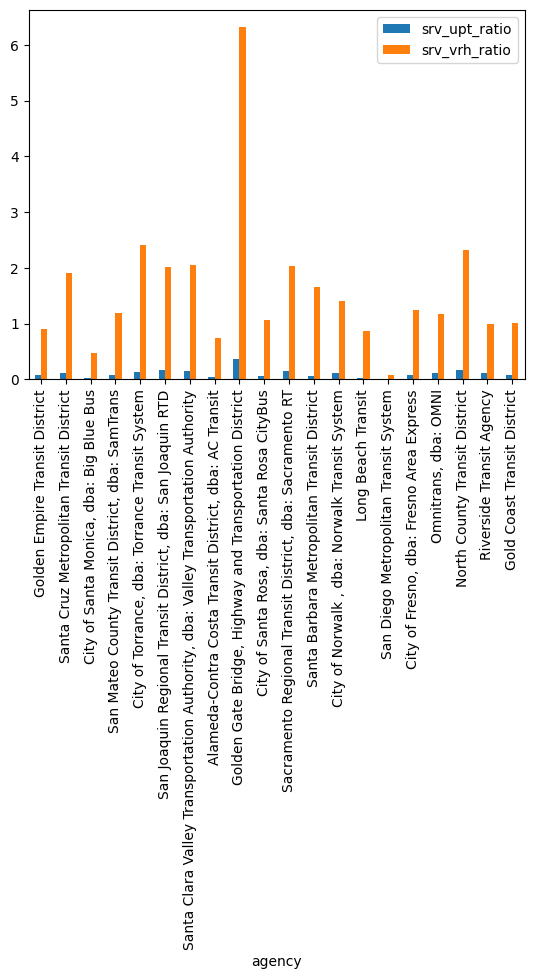

In [39]:
# srv:upt and srv:vrh compare

service_v_upt_no_outliers[:20].plot(
    x = "agency",
    y = [
        "srv_upt_ratio", 
        #"unlinked_passenger_trips",
        "srv_vrh_ratio"
    ],
    kind = "bar",
    #secondary_y = "total_service_vehicles"  
)

/opt/conda/lib/python3.11/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Service Vehicle to VRH Ratio')

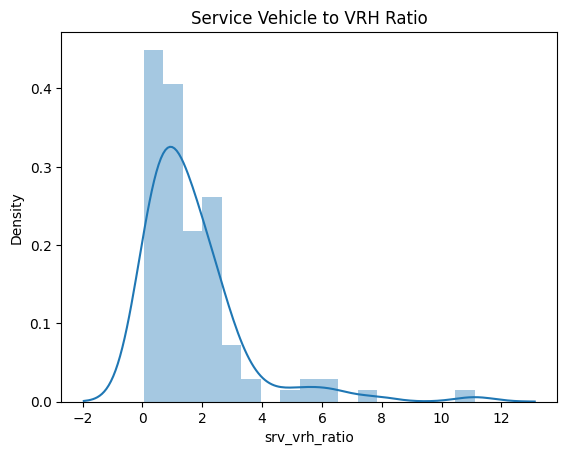

In [40]:
sns.distplot(service_v_upt_no_outliers[service_v_upt_no_outliers["srv_vrh_ratio"]>0]["srv_vrh_ratio"]).set_title('Service Vehicle to VRH Ratio')

/opt/conda/lib/python3.11/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Service Vehicle to UPT Ratio')

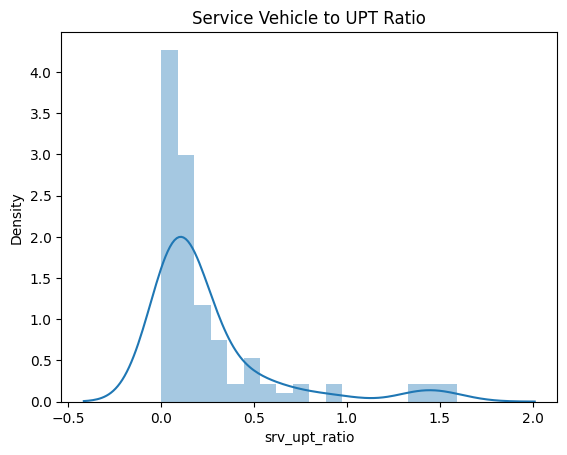

In [41]:
sns.distplot(service_v_upt_no_outliers[service_v_upt_no_outliers["srv_upt_ratio"]>0]["srv_upt_ratio"]).set_title("Service Vehicle to UPT Ratio")

In [42]:
def make_scatter(
    data,
    x_ax,
    y_ax
):
    chart = alt.Chart(data).mark_point().encode(
    x = x_ax,
    y = y_ax,
    tooltip=[x_ax,y_ax],
    ).properties(title=f"{x_ax} vs. {y_ax}").interactive()

    return chart + chart.transform_regression(x_ax,y_ax).mark_line()

In [43]:
make_scatter(service_v_upt_no_outliers[service_v_upt_no_outliers["Number of Vehicles"]>0],"Number of Vehicles","unlinked_passenger_trips_upt")

alt.LayerChart(...)

In [44]:
make_scatter(service_v_upt_no_outliers[service_v_upt_no_outliers["Number of Vehicles"]>0],"Number of Vehicles","actual_vehicles_passenger_car_revenue_hours")

alt.LayerChart(...)

In [45]:
service_v_upt_no_outliers.columns.to_list()

['NTD ID',
 'Agency Name',
 'Reporter Type',
 'Number of Vehicles',
 'ntd_id',
 'agency',
 'unlinked_passenger_trips_upt',
 'actual_vehicles_passenger_car_revenue_hours',
 'actual_vehicles_passenger_car_revenue_miles',
 '_merge',
 'srv_upt_ratio',
 'srv_vrh_ratio']

In [46]:
make_scatter(service_v_upt_no_outliers[service_v_upt_no_outliers["Number of Vehicles"]>0],"Number of Vehicles","actual_vehicles_passenger_car_revenue_miles")

alt.LayerChart(...)